# Numerical Integration

Here we will study numerical integration in Python as provided by routines in `scipy.integrate`.  The main routine is `quad`, but there are many other methods implemented that are useful in some circumstances.

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Documentation

As always we should check the documentation.  There are routines for Newton-Cotes integration, `newton_cotes`, for integrating functions, in particular `romberg` and `quad`, and for integrating from tabulated values, in particular `cumtrapz`, `simps`, and `romb`.  We should check the documentation for all of these, and some of them may be used in the lab and homework assignments.  Here we will only look at a few of them.

In [2]:
integ?

In [ ]:
integ.

In [ ]:
integ.newton_cotes?

In [ ]:
print("n=1: [trapezoidal rule] ", integ.newton_cotes(1))
print("n=2: [Simpson's rule] ", integ.newton_cotes(2))
print("n=10: ", integ.newton_cotes(10))

In [ ]:
integ.cumtrapz?

In [ ]:
integ.romberg?

In [ ]:
integ.quad?

The work horse routine is `quad`.  It is actually a wrapper for many integration routines and techniques.  In fact, it has so many features that it has its own function to explain some of its more esoteric features, `quad_explain`.

In [ ]:
integ.quad_explain()

## Using `quad`

The main and most powerful routine for integrating functions is `quad`.  To get started using it let us consider a simple integral,
$$ \int_0^2 \mathrm{e}^x \,\mathrm{d}x = \mathrm{e}^2 - 1. $$
We can perform this integral using `quad` as shown below.

In [3]:
integ.quad(np.exp, 0, 2)

(6.3890560989306495, 7.093277186654589e-14)

Notice that `quad` **returns two quantities.** As described in the documentation these are the value of the integral and an estimate of the error in the integral.  Note that this error estimate is based on the convergence of the integration algorithm, it is **not** the true error.  If `quad` knew the true value it would return it and the error would be zero!

In principle we should always check the error estimate as this is an indication of the convergence of the algorithm and how much we should trust the result.  Since `quad` returns the results in what is a called a `tuple` in Python, we can store the results using
```python
(res, err) = integ.quad(np.exp, 0, 2)
```

Alternatively we can entirely ignore the error.  This is not good practice, but is often expedient (that is, once we know the integral converges we can start ignoring the error).  Another common idiom is thus to just pull out the result by extracting the first element of the `tuple` (the element with index 0),
```python
res = integ.quad(np.exp, 0, 2)[0]
```

For our simple case we have ...

In [4]:
res_true = np.exp(2) - 1
(res, err) = integ.quad(np.exp, 0, 2)
print("True value of integral =", res_true, " quad estimate of integral =", res)
print("True error in integral =", np.abs(res_true-res), " quad estimate of error =", err)

True value of integral = 6.38905609893065  quad estimate of integral = 6.3890560989306495
True error in integral = 8.881784197001252e-16  quad estimate of error = 7.093277186654589e-14


We can get detailed information of what `quad` is doing by using `full_output=True`.

In [5]:
integ.quad(np.exp, 0, 2, full_output=True)

(6.3890560989306495,
 7.093277186654589e-14,
 {'neval': 21,
  'last': 1,
  'iord': array([         1,    6029375,    3801155,    5570652,    6619251,
            7536754,    4849756,    7143521,    7536741,    4259932,
            6357102,    7274595,    6553710,    3342433,    7077980,
            6422633,    7536732,    7602281,    2949221,    6357104,
            7012451,    6750305,    7536741,    7536732,    6881379,
            7929968,    6881372,    7602286,    7471205,    7274608,
            6357100,    6619252,    6226012,    7340127,    6488185,
            6488161,    6619240,    6226015,    6226012,    7667811,
            6881378,    3014755,    7340131,    7602297,    7274600,
            2949230,    3604531,    7340078,    6488185, 1716060160],
        dtype=int32),
  'alist': array([0.00000000e+000, 9.87116690e-312, 4.32106881e-312, 0.00000000e+000,
         1.69484279e-319, 4.32106881e-312, 0.00000000e+000, 9.87123283e-312,
         0.00000000e+000, 0.00000000e+000, 

This returns a lot of extra information in a data structure called a `dictionary` in Python.  (This is called an associative array, hash map, or something similar in other languages.)  It is best to store this and look at it more closely.  The full details are contained in the description provided by `quad_explain`.  We will focus on only one entry, the number of function evaluations required which is contained in `neval`.

In [ ]:
(res, err, info) = integ.quad(np.exp, 0, 2, full_output=True)
print("Evaluation of the integral required", info['neval'], "function evaluations")

In [ ]:
info.keys()

## Incandescent Light Bulb

The great invention of Edison that brought safe, controllable light to the world has now largely been relegated to the dustbin of history due to its energy inefficiency.  Here we will study this through a simple model.  We treat the light bulb as a black body.  This is a simple approximation that describes many of the features of a light bulb, but is not a complete model.  The intensity of a black body, the energy emitted per unit time in some solid angle as a function of the wavelength of the emitted light, is
$$ I(\lambda) = \frac{2\pi A h c^2}{\lambda^5 (\mathrm{e}^{hc/\lambda k_B T} - 1)}, $$
where $A$ is the surface area of the black body, $h=6.626\times10^{-34}\;\mathrm{J/s}$ is Planck's constant, $c$ is the speed of light, $k_B=1.381\times10^{-23}\;\mathrm{J/K}$ is Boltzmann's constant, and $T$ is the temperature of the object.

A black body at any temperature emits at all wavelengths.  Our eye is only sensitive to "visible light", that is, wavelengths roughly in the range $300\le\lambda(\mathrm{nm})\le750$.  Any radiation emitted at smaller or larger frequencies is thus "wasted energy" as far as we are concerned.  For this reason let us define the efficiency, $\eta$, as the ratio of the emitted radiation we can observe to the total emitted radiation
$$ \eta \equiv \frac{\int_{\lambda_1}^{\lambda_2} I(\lambda) \mathrm{d}\lambda}{\int_0^\infty I(\lambda) \mathrm{d}\lambda}. $$

To use these we transform it into a simpler form.  Let $x_i(T) \equiv \frac{hc}{\lambda_i k_B T}$ and note that we can perform the integral in the denominator leaving the efficiency as
$$ \eta(T)  = \frac{15}{\pi^4} \int_{x_2(T)}^{x_1(T)} \frac{x^3}{\mathrm{e}^x-1} \mathrm{d}x. $$
We will use $\lambda_1=300\;\mathrm{nm}$ and $\lambda_2=750\;\mathrm{nm}$ in what follows to estimate the efficiency of a light bulb for visible radiation.

### Loops

We wish to find the temperature at which the light bulb runs at maximum efficiency.  To do this we need to evaluate the efficiency for a grid of temperatures.  Unfortunately `quad` does not evaluate the integral over an array of end points so we must resort to writing a loop. (If you are familiar with list comprehensions in Python, that is another option.)  This is one case where we cannot easily avoid doing so.

### Optimal Temperature

To calculate the optimal temperature we construct a grid of temperature values and loop over them.

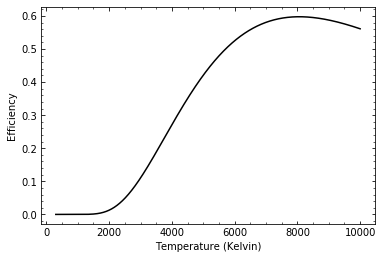

In [6]:
# Some constants to get us going.
# We will use the temperature measured in Kelvin.
Planckh = 6.62606957e-34 # J s, Planck's constant
speedc = 2.99792458e+08 # m/s, speed of light
kB = 1.3806488e-23 # J/K, Boltzmann's constant
lam1 = 300e-9 # m
lam2 = 750e-9 # m
# Conversion factors need for the efficiency.
x1T = Planckh*speedc / (lam1*kB) # x1*T, in K
x2T = Planckh*speedc / (lam2*kB) # x1*T, in K

def I(x) :
    """Blackbody intensity in dimensionless form."""
    return x**3 / (np.exp(x)-1)

def efficiency(T) :
    """Efficiency of a blackbody.  This is defined as the intensity
    emitted in visible wavelengths normalized by the total intensity
    of a blackbody with temperature, T, specified in Kelvin.
    """
    return 15/np.pi**4 * integ.quad(I, x2T/T, x1T/T)[0]

T = np.linspace(300, 10000, 5000) # Kelvin
eta = np.zeros_like(T)
for j in range(len(T)) :
    eta[j] = efficiency(T[j])
    
# A quick plot to see what it looks like
plt.plot(T, eta, 'k-')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Efficiency');

From the quick plot the efficiency always remains below 60 percent and is a maximum at a rather high temperature.  We can find this maximum in a number of ways.  One approach is to find where the derivative is zero.  We can do this using a spline and a root finder.

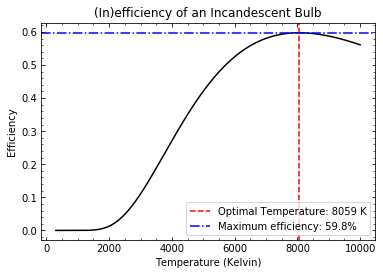

In [7]:
eta_spline = interp.InterpolatedUnivariateSpline(T, eta)
# Calculate its derivative as a function
eta_spline_deriv = eta_spline.derivative()
Toptimal = opt.brentq(eta_spline_deriv, 4000, 9000)
etamax = efficiency(Toptimal)

# Make a nice plot of the results
plt.plot(T, eta, 'k-')
plt.axvline(Toptimal, color='r', ls='--', label=f'Optimal Temperature: {Toptimal:.0f} K')
plt.axhline(etamax, color='b', ls='-.', label=f'Maximum efficiency: {100*etamax:.1f}%')
plt.legend(loc='best')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Efficiency')
plt.title('(In)efficiency of an Incandescent Bulb');

The optimal temperature is quite high and the value is not too surprising.  The Sun is the dominant source of light on the Earth and it can also be approximated as a black body.  The surface temperature of the Sun is approximately 5800 K, close to the optimal temperature we find.  The exact connection between the two and the role evolution plays in this is more subtle and must be addressed with some care.  We could easily include a "response function" for how the eye responds as a function of wavelength in our analysis, see <a href="http://www.phys.ufl.edu/~hagen/phz4710/readings/AJPSofferLynch.pdf">Soffer and Lynch (1999)</a> for more details.  This would be a more accurate assessment.  Even without that we get the main point, the optimal temperature for operating an incandescent bulb is quite high.

Overall we see that an incandescent bulb is incredibly inefficient, particularly since there is no way we would run such a bulb at approximately 8000 K!  Even if we did we would only be running at about 60 percent efficiency.  Of course this analysis should not be taken too literally.  Many things can be/were done to improve the efficiency, an incandescent bulb is not a perfect blackbody, *etc*.  Even so, it shows how big a problem must be overcome to make them even marginally efficient.  Alternate technologies have thus supplanted the venerable incandescent bulb.